SINDy for cell apoptosis. This is meant to show the efficacy of SINDy compared to the neural network based approach.


### Instructions 
1. Connect to a run-time, not GPU
2. Run all cells for default configurations.
3. Play around with noise, sparsity, basis functions, etc.

This supplements the presentation for APPM 5720: Data Driven Modeling.
Authors: Josh Myers-Dean, Leonardo Orozco, and Wenhao Wang

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/joshmyersdean/APPM5720-SBINN/blob/main/sindy.ipynb)

# Setting up the environment
Restart runtime after this and DO NOT run cell again, sad things will happen

In [1]:
%pip uninstall pysindy==0.15 -y -q 
%pip uninstall pysindy==1.6.3 -y -q
%pip uninstall scikit-learn==1.0.2 -y -q
%pip uninstall scikit-learn==0.24.1 -y -q

%pip install scipy==1.7.3 -q
%pip install scikit-learn==0.24.1 -q
%pip install pysindy==1.6.3 -q

     |████████████████████████████████| 38.1 MB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, which is not installed.
sklearn-pandas 1.8.0 requires scikit-learn>=0.15.0, which is not installed.
mlxtend 0.14.0 requires scikit-learn>=0.18, which is not installed.
lightgbm 2.2.3 requires scikit-learn, which is not installed.
librosa 0.8.1 requires scikit-learn!=0.19.0,>=0.14.0, which is not installed.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, which is not installed.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ye

In [1]:
import numpy as np
from scipy.integrate import odeint
import pysindy as ps
import warnings
import matplotlib.pyplot as plt
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)

# Apoptosis Model Data generation

You can find the full version of parameter settings <br>
At time 0, our initial condition is $x(0) = [1.34 × 10^5, 1.0 ×
10^5, 2.67 × 10^5, 0.0, 0.0, 0.0, x_7^0 ,0.0]$ (molecules/cell)<br>
when $x^0_7 =2.9 × 10^3$
leads to cell death
and $x^0_7 = 2.9 × 10^4$
leads to cell survival.

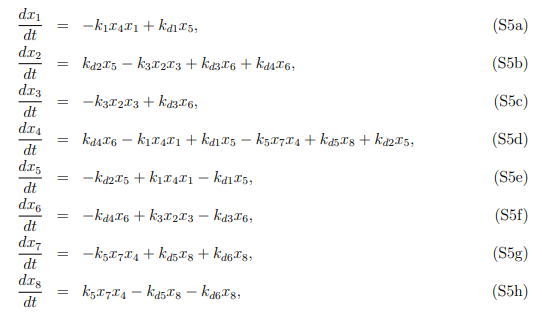

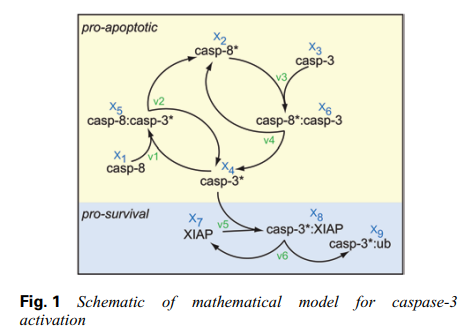

## Then we make a function for the system of ODE describe the apoptosis process

In [2]:
def apoptosis_model(
    t, x0, k1, kd1, kd2, k3, kd3, kd4, k5, kd5, kd6,
):
    def func(x, t):
        v4_1 = kd1 * x[4]
        v4_2 = kd2 * x[4]
        v5_3 = kd3 * x[5]
        v5_4 = kd4 * x[5]
        v7_5 = kd5 * x[7]
        v7_6 = kd6 * x[7]
        v03 = k1 * x[3] * x[0]
        v12 = k3 * x[1] * x[2]
        v36 = k5 * x[6] * x[3]

        return [
            -v03 + v4_1,
            v4_2 - v12 + v5_3 + v5_4,
            -v12 + v5_3,
            v5_4 - v03 + v4_1 - v36 + v7_5 + v4_2,
            -v4_2 + v03 - v4_1,
            -v5_4 + v12 - v5_3,
            -v36 + v7_5 + v7_6,
            v36 - v7_5 - v7_6,
        ]

    return odeint(func, x0, t)

## Then we solve the system from time 0 to 60 hours (0.1 hour increment), we also non-dimensionalize the data and add some noise in this step
The noise we add here is the white noise follows gaussian distribution.<br>
$ϵ \sim Guassian(0,noise\cdot std(x_i))$

In [3]:
noise=0.002    # select your noise level, note that the precision of prediction will decay very fast!

In [4]:
t = np.arange(0, 60, 0.1)[:, None]
t_scale = 3600
c_scale = 1e1

# Data
x7=2.9e3  # death
#x7=2.9e4  # survival
x0 = [1.34e5, 1e5, 2.67e5, 0, 0, 0, x7, 0] 
x0 = [x / c_scale for x in x0]
var_list = [2.67e-9, 1e-2, 8e-3, 6.8e-8, 5e-2, 1e-3, 7e-5, 1.67e-5, 1.67e-4]
var_list = [v * t_scale for v in var_list]
for i in [0, 3, 6]:
    var_list[i] *= c_scale
y = apoptosis_model(np.ravel(t), x0, *var_list)
yclean=np.copy(y)
# Add noise
if noise > 0:
    std = noise * y.std(0)
    tmp = np.copy(y[len(t) // 2])
    y[1:, :] += np.random.normal(0, std, (y.shape[0] - 1, y.shape[1]))
    y[len(t) // 2] = tmp


## Select the observations from y

In [5]:
train_number=500 # select your train number from 0 to 550

In [6]:
yobserve=y[0:train_number,:]

## Now we can visualize the $x_i$

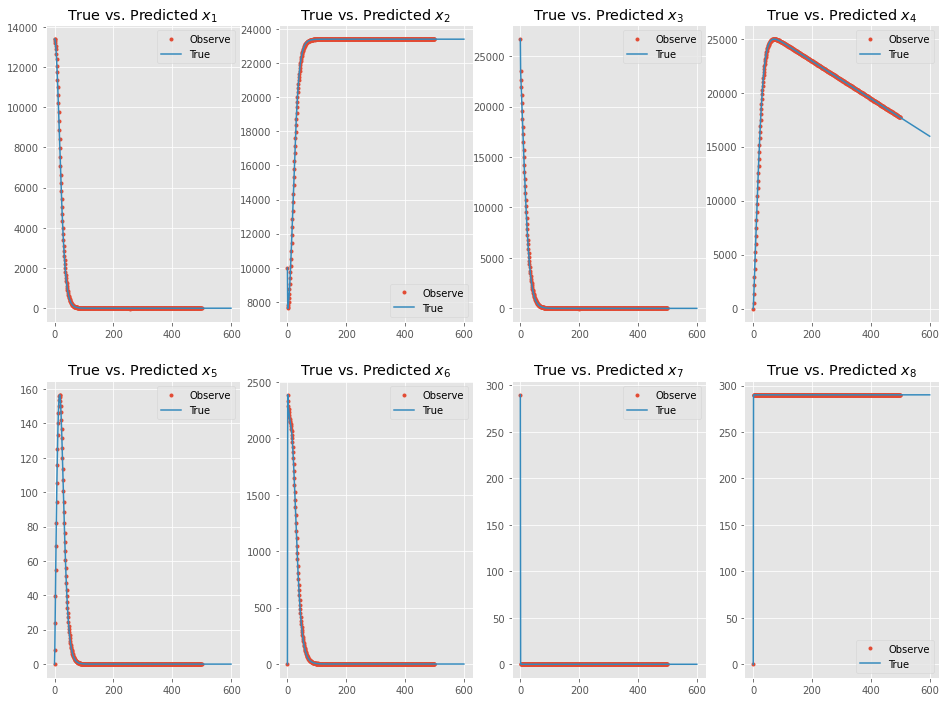

In [7]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
fig, ax = plt.subplots(2,4, figsize=(16,12))
ax = ax.flatten()
for i in range(y.shape[1]):
  ax[i].plot(yobserve[:, i], 'o', markersize=3,label='Observe')
  ax[i].plot(yclean[:, i], label='True')
  ax[i].set_title(f"True vs. Predicted $x_{i+1}$")
  ax[i].legend()

## SINDy

In [8]:
thrs=0.025  #select your threshold from 0 to 1.

In [9]:
optimizer = ps.STLSQ(threshold=thrs)
model = ps.SINDy(
    feature_library=ps.PolynomialLibrary(degree=1),
    feature_names=["x1", "x2", 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'],
    optimizer=optimizer
)
model.fit(y[0:train_number,:], t=.1)
model.print()

(x1)' = 8437.346 1 + -0.219 x1 + -0.083 x2 + 0.090 x3 + -25.574 x5 + -0.286 x6 + -24.017 x7 + -22.393 x8
(x2)' = 373168.693 1 + 6.334 x1 + -11.276 x2 + -14.959 x3 + -433.078 x5 + 36.784 x6 + 62.274 x7 + -376.958 x8
(x3)' = 358300.500 1 + 6.348 x1 + -10.891 x2 + -14.643 x3 + -451.665 x5 + 32.533 x6 + 42.051 x7 + -356.707 x8
(x4)' = 34366.362 1 + 0.405 x1 + -1.786 x2 + -1.864 x3 + -57.016 x5 + 7.715 x6 + 109.105 x7 + 25.022 x8
(x5)' = 3068.538 1 + 0.036 x1 + -0.068 x2 + -0.060 x3 + -2.164 x5 + -4.244 x7 + -5.061 x8
(x6)' = -378149.903 1 + -6.047 x1 + 11.426 x2 + 14.840 x3 + 458.164 x5 + -36.222 x6 + -52.670 x7 + 382.024 x8
(x7)' = 45504.503 1 + 0.740 x1 + -1.355 x2 + -1.756 x3 + -53.632 x5 + 4.087 x6 + 2.245 x7 + -47.554 x8
(x8)' = -45533.219 1 + -0.739 x1 + 1.356 x2 + 1.755 x3 + 53.630 x5 + -4.085 x6 + -2.216 x7 + 47.579 x8


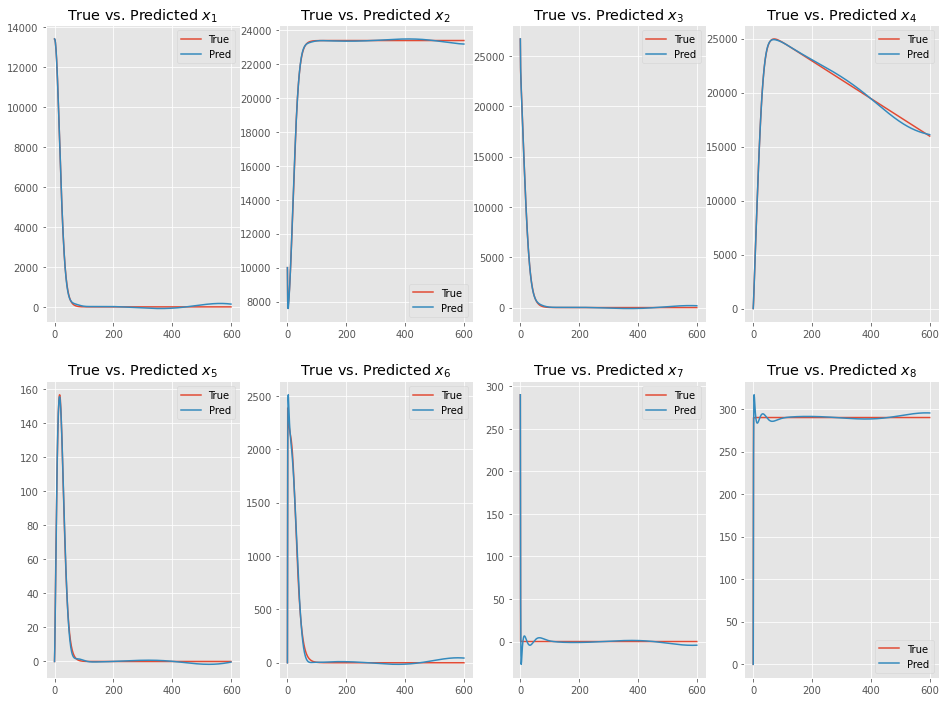

In [10]:
sim = model.simulate(x0 = x0, t=t[:,0])
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
fig, ax = plt.subplots(2,4, figsize=(16,12))
ax = ax.flatten()
for i in range(y.shape[1]):
  ax[i].plot(yclean[:, i], label='True')
  ax[i].plot(sim[:, i], label='Pred')
  ax[i].set_title(f"True vs. Predicted $x_{i+1}$")
  ax[i].legend()
